# Imports

In [10]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from custom_functions import wrangler
import plotly.express as px
import missingno as msno 


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 50) 

# Primary Data Examination & Cleaning

In [12]:
df = pd.read_csv('data/eda.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64
 18  sqft_l

<Axes: >

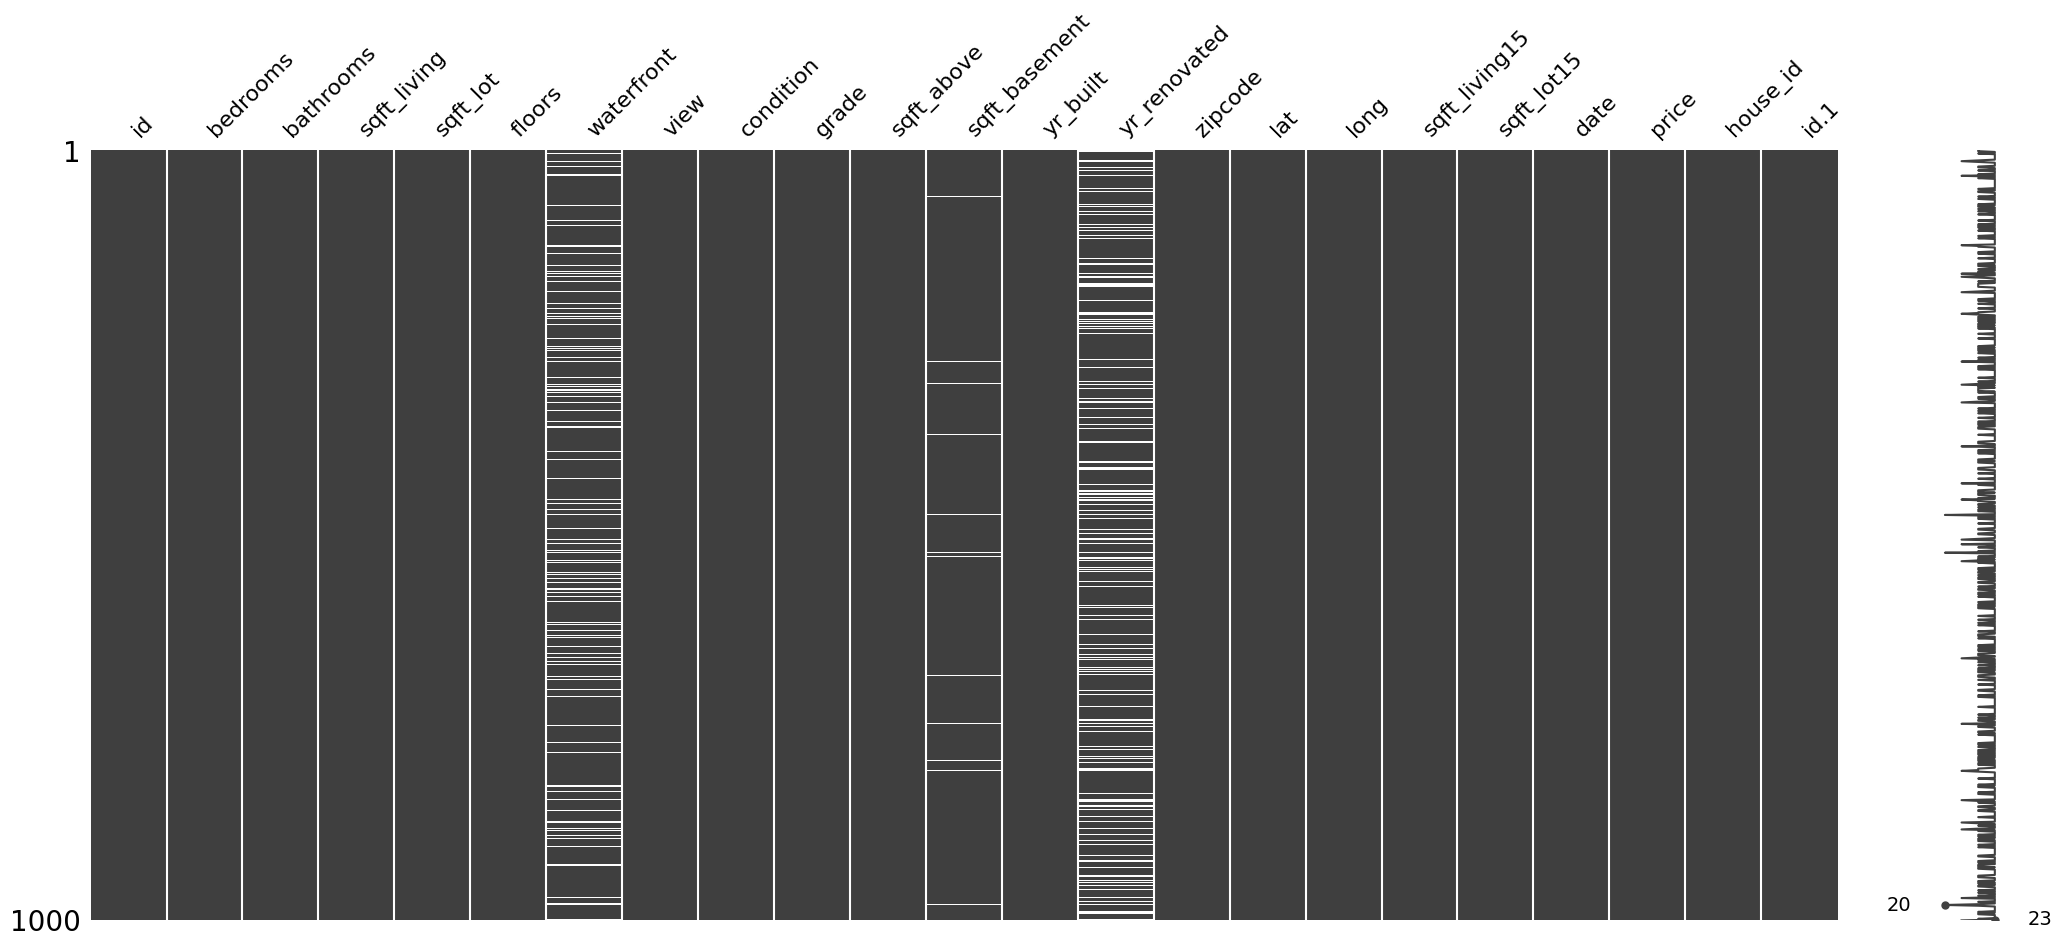

In [11]:
msno.matrix(df.sample(1000))

In [6]:
clean_df = wrangler(df)

In [9]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   price            21597 non-null  int64         
 1   price_per_sqft   21597 non-null  int64         
 2   sqft_living      21597 non-null  int64         
 3   grade            21597 non-null  int64         
 4   condition        21597 non-null  int64         
 5   center_distance  21597 non-null  float64       
 6   bedrooms         21597 non-null  int64         
 7   bathrooms        21597 non-null  float64       
 8   floors           21597 non-null  float64       
 9   sqft_lot         21597 non-null  int64         
 10  sqft_above       21597 non-null  int64         
 11  sqft_basement    21597 non-null  int64         
 12  sqft_living15    21597 non-null  int64         
 13  sqft_lot15       21597 non-null  int64         
 14  yr_built         21597 non-null  int64